In [1]:
# Imports

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

# Keras
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Adadelta
from keras.regularizers import L1L2, L2

In [2]:
# Load in the data
df = pd.read_csv('./train_data.csv')
print(df.shape)

# Make boolean columns into integer columns
df.replace({False: 0, True: 1}, inplace=True)

# Split the data into target labels y and features X
num_train = df.select_dtypes(include=np.number)
train_y = df.target
train_X = df.drop(['target'], axis = 1)

# Fill empty values in the train data 
train_X_columns = train_X.columns
train_X = train_X.fillna(-1)

# Custom z-score method because scipy caused NaN problems in some columns
def z_score(arr):
    mean = np.mean(arr, axis = 0)
    std = np.std(arr, axis = 0)
    std[std == 0] = 1
    return (arr-mean)/std

# Add gaussian noise to the array
def add_gauss_noise(arr, var = 0.1, mu = 0):
    row,col= arr.shape
    
    # Convert the variance to sigma (variance = sigma^2)
    sigma = var**0.5
    
    # Create an array with the Gaussian noise given the sigma, mu parameters
    # Then reshape to the same shape as the array arr
    gauss = np.random.normal(mu,sigma,(row,col)).reshape(row,col)
    
    # Add the noise to the array and return
    return arr + gauss


# Normalize the data using z-score standardization
train_X = z_score(train_X.to_numpy(dtype = np.float64)) #.to_numpy(dtype = np.float64)
train_df = pd.DataFrame(train_X)

y = to_categorical(train_y, num_classes = 3)

(1593, 2651)


In [47]:
def create_model(input_dim):
    # Create model
    model = Sequential()
    
    # 2 dense layers with relu activation
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu')) 
    
    # Last layer is softmax
    model.add(Dense(3, activation='softmax'))
    
    # Optimizer
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

def create_improved_model(input_dim, dropout = 0.1, lr = 1e-2):
    # Initialize HE initializers and L2 regularizer
    initializer = keras.initializers.HeNormal()
    regularizer = L2(0.01)
    # create model
    model = Sequential()
    
    # Use 3 dense layers with relu activation, with batchnormalization and dropout inbetween
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_initializer = initializer))
    model.add(BatchNormalization())
#     model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_initializer = initializer)) 
    model.add(BatchNormalization())
#     model.add(Dropout(dropout))
#     model.add(Dense(64, activation='relu', kernel_initializer = initializer, kernel_regularizer = regularizer))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout))
    
    # Last layer is softmax
    model.add(Dense(3, activation='softmax'))
    
    # SGD optimizer
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model


In [4]:
from sklearn.model_selection import StratifiedKFold
def train_network(model, X_train, y_train, X_val, y_val, best_val_acc = 0, plot = True,
                  n_epochs = 10, batch_size = 32, verbose = 1, save = False, path = 'best_model'):

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = best_val_acc
    best_val_loss = 1
    best_acc_epoch = 0
    best_loss_epoch = 0

    # Loop over epochs
    for epoch in range(n_epochs):

        # Train model
        results = model.fit(X_train, y_train, batch_size = batch_size, verbose = verbose)

        # Get training loss and accuracy and append to lists
        train_losses.append(results.history['loss'])
        train_accs.append(results.history['accuracy'])

        # Get performance (i.e. loss and accuracy) on validation set
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose = verbose)

        # Append to lists
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Keep track of which epoch had the best validation accuracy and store the corresponding model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_acc_epoch = epoch
            if save:
                model.save(path)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_loss_epoch = epoch

    # Visualise the performance of the model for the epochs
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        ax[0].plot(train_losses) 
        ax[1].plot(train_accs)
        ax[0].plot(val_losses)
        ax[1].plot(val_accs)

        # Text and legend for the plot
        ax[0].legend(['train loss', 'validation loss'],
                  loc='upper right', bbox_to_anchor=(1,1))
        ax[1].legend(['train accuracy', 'validation accuracy'],
                  loc='lower right', bbox_to_anchor=(1,0))
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('loss')
        ax[0].set_title('Model performance (loss)')
        
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('accuracy')
        ax[1].set_title('Model performance (accuracy)')

        plt.show()

    # Print the performance values (accuracies, loss) for train, validation
    print('Train accuracy:\t\t\t{:.2f}\tTrain loss: {:.2f}'.format(train_accs[-1][0], train_losses[-1][0]))
    print('Validation accuracy:\t\t{:.2f}\tValidation loss: {:.2f}'.format(val_accs[-1], val_losses[-1]))
    print('Best validation accuracy:\t{:.2f} (epoch {:})'.format(best_val_acc, best_acc_epoch))
    print('Best validation loss:\t\t{:.2f} (epoch {:})'.format(best_val_loss, best_loss_epoch))
    
    return train_losses, train_accs, val_losses, val_accs
        

def train_model(train_X, y, improved = False):
    # Make a 80/20 train-test split and create the model
    X_train, X_val, y_train, y_val = train_test_split(train_X, y, stratify = y, test_size=0.2, shuffle = True)
    if improved:
        model = create_improved_model(train_X.shape[1])
    else:
        model = create_model(train_X.shape[1])

    # Train the model
    save = False
    return train_network(model, X_train, y_train, X_val, y_val, n_epochs = 20, batch_size = 32, verbose = 0, 
                         save = save, plot = False)


In [12]:
# Train the model at different levels of noise
tl, ta, vl, va = [], [], [], []
var_str = []
for v in np.arange(0, 11, 1):
    stats = train_model(add_gauss_noise(train_X, var = v), y)
    tl.append(stats[0])
    ta.append(stats[1])
    vl.append(stats[2])
    va.append(stats[3])
    v_str = 'var: {:.1f}'.format(v)
    var_str.append(v_str)
    print(v_str)

Train accuracy:			0.94	Train loss: 0.14
Validation accuracy:		0.79	Validation loss: 0.79
Best validation accuracy:	0.81 (epoch 10)
Best validation loss:		0.66 (epoch 7)
var: 0.0
Train accuracy:			1.00	Train loss: 0.00
Validation accuracy:		0.76	Validation loss: 1.09
Best validation accuracy:	0.76 (epoch 16)
Best validation loss:		0.82 (epoch 0)
var: 1.0
Train accuracy:			1.00	Train loss: 0.00
Validation accuracy:		0.68	Validation loss: 1.40
Best validation accuracy:	0.68 (epoch 9)
Best validation loss:		1.00 (epoch 0)
var: 2.0
Train accuracy:			1.00	Train loss: 0.00
Validation accuracy:		0.63	Validation loss: 1.46
Best validation accuracy:	0.64 (epoch 1)
Best validation loss:		1.00 (epoch 0)
var: 3.0
Train accuracy:			1.00	Train loss: 0.00
Validation accuracy:		0.67	Validation loss: 1.17
Best validation accuracy:	0.67 (epoch 11)
Best validation loss:		0.97 (epoch 2)
var: 4.0
Train accuracy:			1.00	Train loss: 0.00
Validation accuracy:		0.69	Validation loss: 1.46
Best validation accurac

In [13]:
# Function to plot the statistics of the model
def plot_stats(stat, var_str, title, stat_str):
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
    plt.figure(figsize=(16,8))
    for s in stat:
        plt.plot(s)
    plt.legend(var_str)
    plt.title('{} given different levels of noise'.format(title))
    plt.ylabel(stat_str)
    plt.xlabel('epochs')
    plt.show()

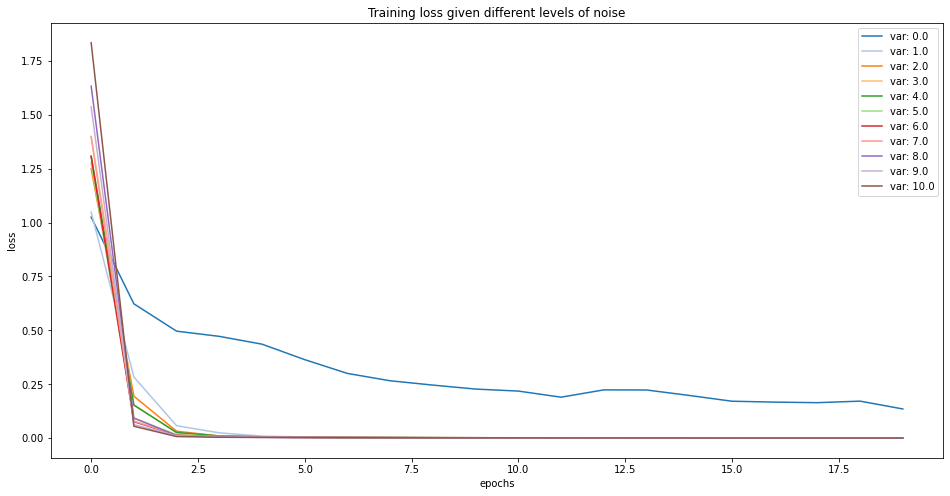

In [14]:
plot_stats(tl, var_str, 'Training loss', 'loss')

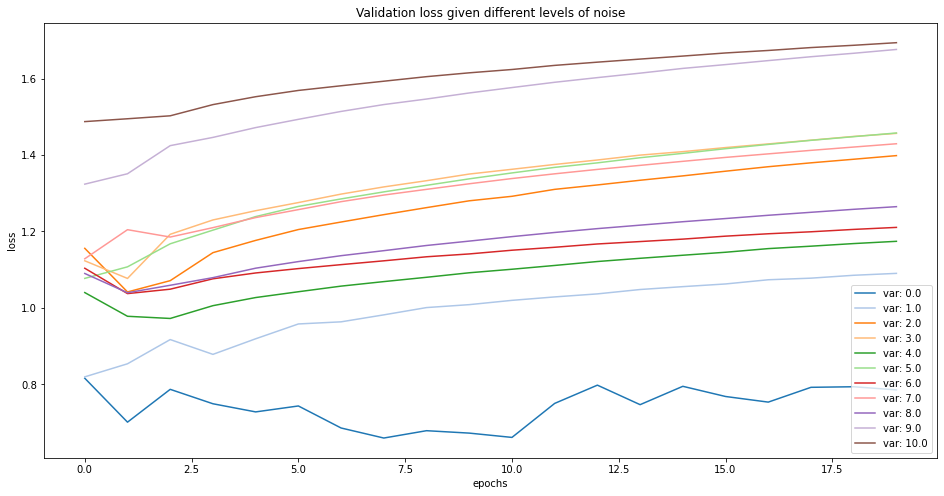

In [15]:
plot_stats(vl, var_str, 'Validation loss', 'loss')

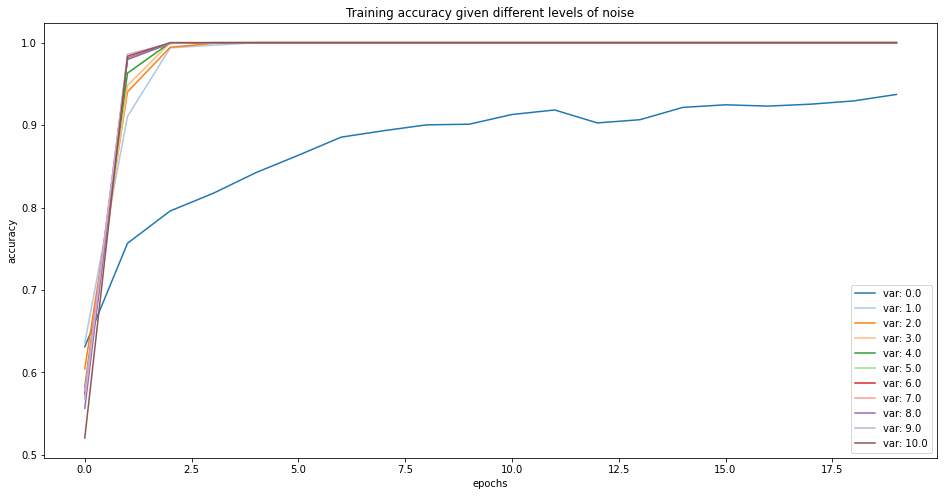

In [16]:
plot_stats(ta, var_str, 'Training accuracy', 'accuracy')

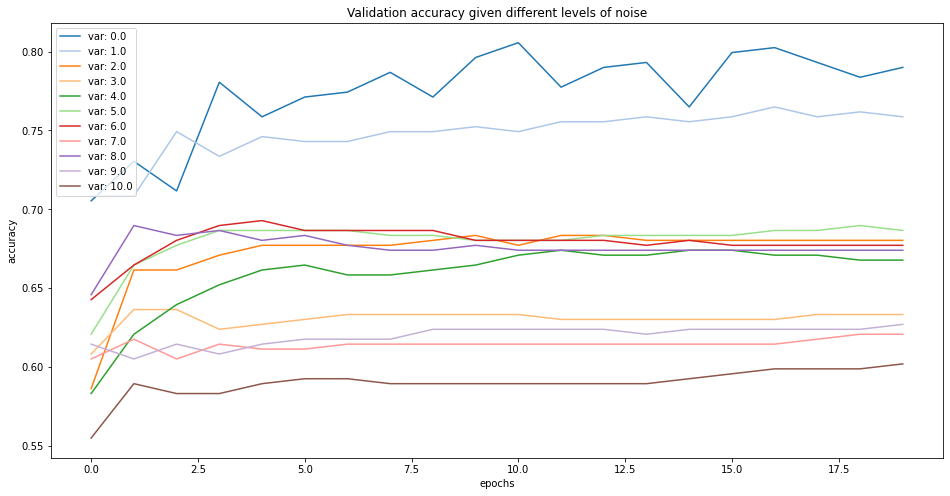

In [17]:
plot_stats(va, var_str, 'Validation accuracy', 'accuracy')

In [48]:
# Running the improved model (final version)
stats_improved = train_model(add_gauss_noise(train_X, var = 0), y, improved = True)

Train accuracy:			0.91	Train loss: 0.23
Validation accuracy:		0.77	Validation loss: 0.63
Best validation accuracy:	0.80 (epoch 17)
Best validation loss:		0.58 (epoch 9)
